# Import Libraries

In [1]:
####### INIT ######################################################################################

from context import rmlib
#Imports 
from time import sleep
import numpy as np
import rmlib
from rmlib.rmtools.asm_BT_lib.asm_tree_Basic import augment_RM
import rmlib.rmtools as rm
from config import robotConfig

robot = rmlib.robot.Robot( robotConfig )

augment_RM( robot )

%store -r  #loads variables attached to this notebook

####### LIBS ######################################################################################

# Import Pytrees
import py_trees
from py_trees.tests import Timeout_Success
from py_trees.composites import Sequence , Selector

from rmlib.rmtools.asm_BT_lib.asm_tree_Basic import *
from rmlib.rmtools.asm_BT_lib.asm_tree_FT_based import *

import math
from pmath import translate_pose , get_disance_between_poses , pose_components

from utils import is_matx_list
from math import radians

print( "\n##!## READY ##!##" )

Loaded: /home/nvidia/dev_rmstudio/rmlib/rmlib/rmtools Exists?: True
Loaded: /home/nvidia/dev_rmstudio/rmlib Exists?: True
Setting up robot please wait...
my_components: {'ft_config': {'module_name': 'sensors.ftsensor_optoforce', 'ip_address': '192.168.0.100', 'remote_port': 10000, 'local_port': 20000, 'class_name': 'OptoForce', 'dataHz': 50.0, 'max_workers': 10, 'filter': {'beta': 0.035, 'alpha': 0.012}, 'remote_ip': '', 'local_ip': '127.0.0.1'}, 'arm_config': {'ip_address': '192.168.0.101', 'max_joint_accel': 1.4, 'class_name': 'UR5', 'default_linear_speed': 0.1, 'max_linear_speed': 0.25, 'xmlrpc_port': '8003', 'default_joint_speed': 0.7, 'module_name': 'arms.ur5', 'max_linear_accel': 1.2, 'max_joint_speed': 1.05, 'default_joint_accel': 0.8, 'default_linear_accel': 0.8}, 'hand_config': {'module_name': 'hands.smarthand', 'class_name': 'SmartHand', 'finger_width_inner': 0.0, 'finger_length': 0.0415, 'finger_depth': 0.014, 'finger_width_outer': 0.015}, 'cam_config': {'module_name': 'came

# Arm Movements

In [2]:
#from task_parameters import taskParams , _TB_side , _M8_TB_height , _M6_TB_height , _M4_TB_height

_DRILL_CONTACT_PRESS = 11.0

#SafePose = robot.arm.get_tcp_pose() #rm.get_tcp_pose()
#%store SafePose


"""
### Move to Safe Pose ###
Basic movements are defined in:
rmlib/rmlib/rmtools/assembly_trees/asm_tree_Basic.py

All of the basic behaviors and trees inherit `py_trees` classes.
""" 

moveNode = Move_Arm( pose  = SafePose , # 4x4 homogeneous coord pose
                     mode  = 'l' ,  # { 'l': linear in task space, 'j': linear in joint space }
                     speed = 0.125 , 
                     accel = 0.35 , 
                     ctrl  = robot ) # Ref to `rmlib` object, stored in `robot` in this NB

NameError: name 'SafePose' is not defined

## Run Behavior
`run_BT_until_done` is a function that ticks the node object provided as an argument at regular intervals.  It will report the final status of the root node and print and ASCII tree representation.   
The default args are likely adequate for your purpose, but it can be found at  
rmlib/rmlib/rmtools/assembly_trees/asm_tree_Basic.py


run_BT_until_done( moveNode )

## Pose Math, Move to Contact, and Tree Building

In [4]:
# Calc a pose 10cm below the `SAFE_POSE`
lowPose = translate_pose( 
    SafePose , 
    [ 0.0 , 0.0 , +0.100 ] , # Translation vector
    dir_pose = 'origin' # { 'origin': lab frame, 'self': relative the argument pose }
)
# Location:  rmlib/rmlib/rmtools/pmath.py

The following cell builds a sequence that makes a relative move, then stores the final pose under a global dictionary key for later retrieval.  
For most 'procedure-like' trees, a Sequence with Memory is used.  
The memory option prevents completed actions from being ticked again until the entire `Sequence` has completed.  
Behaviors will be executed in the order added.

In [8]:
pushTree = Sequence( memory = 1 ) 

poseKey = "TouchdownPose" # String key to store pose that will be used by another tree

# 1. Move to a pose conveniently close to the table
pushTree.add_child(
    Move_Arm( pose = lowPose , mode = 'l',  speed = 0.125 , accel = 0.35 , ctrl = robot ) 
)

# 2. Close the fingers in prep for a probing action
pushTree.add_child(
    Set_Fingers( 
        openState = 0.0 , # Dist b/n fingers in [m], Anything larger than 0.095 interpreted as fully open
        ctrl = robot , # rmlib ref
        waitSec = 0.25 # OpenCM does not block execution, so pause to let fingers physically close
    )
)

"""
### Move Until Reaction Force Encountered ###
Force-based actions are defined in:
rmlib/rmlib/rmtools/assembly_trees/asm_tree_FT_based.py
""" 

# 3. Approach the table at a **gentle speed** and stop when a small reaction force is observed 
pushTree.add_child(
    Move_to_Contact( 
        Fmag      = 3.0 , # Reaction force that triggers stop, Forces below 1.5N aren't reliably detected
        relMove   = [0.0, 0.0, -1.0] , # Specify a move the goes *beyond* where you expect to end up
        biasWrist = 1 , # Bias wrist before beginning motion (Sorry, currently this takes 1-8 seconds)
        mode      = 'l' , 
        speed     = 0.040 , accel = 0.04 , # **gentle speed**
        pull      = 0 , # For pulling actions, reaction force tugs on hand rather than pushes
        ctrl      = robot
    ) # NOTE: This behav. may be used for absolute pose if an argument for `pose` is provided
)

# 4. Remember where we landed
pushTree.add_child(
    Store_Current_Pose( 
        keyString = poseKey , # Blackboard dict key
        ctrl = robot , 
        setOnce = True # Set this flag to prevent the value from being modified once stored
    )
)

# 5. Relative move back up, no condition
pushTree.add_child(
    Move_Arm_Relative( 
        translation = [ -0.035, -0.035, 0.070 ] , # Trans. Vec
        rotation    = [0.0,0.0,0.0] , # Euler angles
        mode = 'l' , speed = 0.125 , accel = 0.35 , 
        stop_cond = None , # A custom stop condition can be passed here if desired
        frame = 'origin' ,
        cond_success = 1 , # Flag true if we are using "stop_cond()==1" to mean *success*, otherwise the reverse
        bias_wrist = 0 , # If `stop_cond` is force based, this is a good idea
        ctrl = robot
    ) # NOTE: If no stop_cond is provided, the this behavior returns true only if the full motion has completed
)

# 6. Now let's recover the pose that we stored before
pushTree.add_child(
    Move_Arm( BB_key = poseKey , # Blackboard dict key passed to `BB_key` instead of a `pose` arg
              mode = 'l',  speed = 0.063 , accel = 0.17 , ctrl = robot ) 
)

# 7. It's a good idea to return to a known safe pose between activities
pushTree.add_child(
    Move_Arm( pose  = SAFE_POSE , ctrl = robot )
)

# 8. Open the fingers
pushTree.add_child(
    Set_Fingers( openState = 1.0 , ctrl = robot , waitSec = 0.0 )
)

print()

[-0.1   -0.1   -3.7    0.029 -0.032 -0.017]
0
4
8
12
16


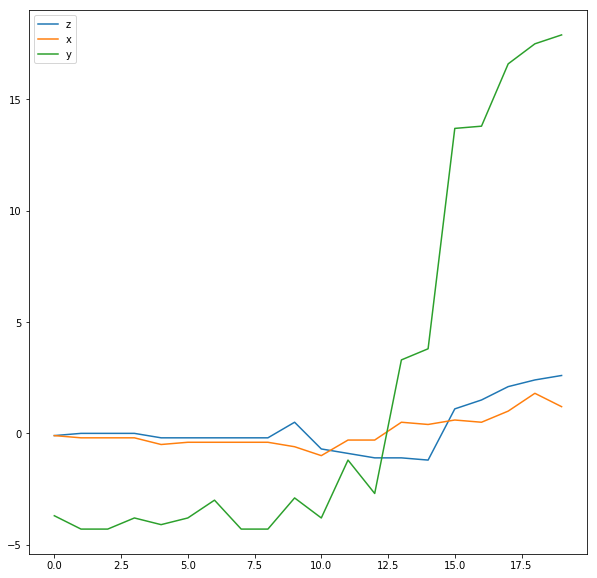

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import time

wrench  = robot.ft.get_wrist_force()
print(wrench)
xforcelist=[]
yforcelist=[]
zforcelist=[]
for i in range(20):
    if i%4==0:
        print(i)
    wrench  = robot.ft.get_wrist_force()
    xforcelist.append(wrench[0])
    yforcelist.append(wrench[1])
    zforcelist.append(wrench[2])
    time.sleep(.1)
    
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(20),xforcelist,range(20),yforcelist,range(20),zforcelist)    
ax.legend({'x','y','z'})
plt.show()

In [2]:
moveNode = Move_Arm( pose  = SAFE_POSE , # 4x4 homogeneous coord pose
                     mode  = 'l' ,  # { 'l': linear in task space, 'j': linear in joint space }
                     speed = 0.125 , 
                     accel = 0.35 , 
                     ctrl  = robot ) # Ref to `rmlib` object, stored in `robot` in this NB
run_BT_until_done(moveNode)

About to run <asm_tree_Basic.Move_Arm object at 0x7f9c0d2eb8> : Move_Arm at 2021-06-23_15-53-19 with 4.0 Hz update frequency ...
Running ...

Root node Move_Arm succeeded!


Run completed! with status: Status.SUCCESS 


Root node Move_Arm was killed by the running script!


## Communication tests

In [3]:
import socket

#HOST = '127.0.0.1'  # Standard loopback interface address (localhost)
HOST = '192.168.0.103'

#192.168.0.103
PORT = 65455        # Port to listen on (non-privileged ports are > 1023)

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind((HOST, PORT))
    s.listen()
    
    #s.settimeout(0.1)
    conn, addr = s.accept()
    with conn:
        print('Connected by', addr)
        s.setblocking(False)
        inputstring=0
        while True:
            #while inputstring!='end':
                inputstring=input("") #Press Enter to continue...
                if (inputstring=='h' or inputstring=='j' or inputstring=='k' or inputstring=='l' or 
                    inputstring=='u' or inputstring=='o'or inputstring=='y' or inputstring=='i' or 
                    inputstring=='z' or inputstring=='x' or inputstring=='d' or inputstring=='c'or
                    inputstring=='home'):
                    
                    data=inputstring.encode('ascii')    
                    print(data)
                    conn.send(data)
                if (inputstring=='g'):
                    data=robot.arm.get_tcp_pose()
                    print(data)
                    print(type(data))
                    data=inputstring.encode('ascii')    
                    print(data)
                    conn.send(data) 
                    
                if inputstring=='end': 
                    data=b'end'
                    print(data)
                    conn.send(data) 
                    break
                #data = conn.recv(1024)
                
                #if not data:
                #    break

Connected by ('192.168.0.102', 47416)


 g


[[-0.99932123 -0.00604125  0.03633989 -0.14518192]
 [-0.00415854  0.99865595  0.05166245 -0.30382647]
 [-0.03660316  0.05147626 -0.99800321  0.26114286]
 [ 0.          0.          0.          1.        ]]
<class 'numpy.ndarray'>
b'g'


 end


b'end'


## Command jog + angle loop, maxed at 2N for any move

In [5]:

import math
from IPython.display import clear_output
import socket


            
            
def exceeds_Z_force2(zLimitF):
        #Condition: Return a function that returns 1 if the z reaction limit is reached 
        def func():
            _DEBUG = 0
            #Stops when Z reaction exceeds value
            wrench = robot.ft.get_wrist_force()
            mag_x   = wrench[0]
            mag_y   = wrench[1]
            mag_z   = wrench[2]
            if _DEBUG: 
                print( "exceeds_Z_force , wrench:" , wrench )
                print("wrench[2]=",wrench[2], "    -zLimitF=",-zLimitF)
            if wrench[2] < -zLimitF:
                builtins._GLOB_FT_FLAG = 1
                #print("pass")
                return 1
            else:
                #print("fail")
                return 0
        return func
    
def exceeds_force(force):
        #Condition: Return a function that returns 1 if the z reaction limit is reached 
        def func():
            _DEBUG = 0
            #Stops when Z reaction exceeds value
            wrench = robot.ft.get_wrist_force()
            mag_x   = wrench[0]
            mag_y   = wrench[1]
            mag_z   = wrench[2]

            if (abs(wrench[0]) > force or 
                abs(wrench[1]) > force or 
                abs(wrench[2]) > force) :
                builtins._GLOB_FT_FLAG = 1
                #print("pass")
                return 1
            else:
                #print("fail")
                if _DEBUG: 
                    print( "exceeds force limit of ", force ,"N  , wrench:" , wrench )
                return 0
        return func      
        
relMoveDistance=0.0254  # 1 inch in meters
rotation_angle=5 # in degrees
rotation_angle=rotation_angle*(math.pi/180)  #convert to radians
#maxForce=2.0 #TapFz uses positive values #Newtons
inputstring=0
forcelimit=4.0
#condition = EXCEEDS_Z_force
#print(dir(condition))


    
#HOST = '127.0.0.1'  # The server's hostname or IP address
HOST = '192.168.0.102'
PORT = 65432        # The port used by the server
robot.ft.bias_wrist_force()
wrench  = robot.ft.get_wrist_force()
print(wrench)
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect((HOST, PORT))
    #message=b'Hello, world'
    #s.sendall(message)
    while True:
        inputstring = s.recv(1024)  #need to make this non-blocking!!!
        print('Received', repr(inputstring))
        if inputstring==b'end':
            break
    
        pushTree = Sequence( memory = 1 ) 
        translation_New     = [0.0,0.0,0.0] 
        rotation_New    = [0.0,0.0,0.0] 

        #inputstring=input("") #Press Enter to continue...
        #if inputstring!='':
        #    clear_output(wait=True)
        if inputstring==b'k': 
            print("+x")
            translation_New   = [-1*relMoveDistance, 0.0 , 0.0]  
        elif inputstring==b'h': 
            print("-x") 
            translation_New   = [relMoveDistance, 0.0 , 0.0]
        elif inputstring==b'u': 
            print("+y")
            translation_New   = [0.0, -1*relMoveDistance, 0.0] 
        elif inputstring==b'j': 
            print("-y")
            translation_New   = [0.0, relMoveDistance, 0.0] 
        elif inputstring==b'o': 
            print("+z")  
            translation_New   =[0.0, 0.0 , relMoveDistance]
        elif inputstring==b'l':  
            print("-z")
            translation_New   =[0.0, 0.0 , -1*relMoveDistance] 
        if inputstring==b'd': 
            print("+pitch")
            rotation_New   = [-1*rotation_angle, 0.0 , 0.0]  
        elif inputstring==b'c': 
            print("-pitch") 
            rotation_New   = [rotation_angle, 0.0 , 0.0]
        elif inputstring==b'z': 
            print("+yaw")
            rotation_New   = [0.0, -1*rotation_angle, 0.0] 
        elif inputstring==b'x': 
            print("-yaw")
            rotation_New   = [0.0, rotation_angle, 0.0] 
        elif inputstring==b'y': 
            print("roll ccw")  
            rotation_New   =[0.0, 0.0 , rotation_angle]
        elif inputstring==b'i': 
            print("roll cw")
            rotation_New   =[0.0, 0.0 , -1*rotation_angle] 

        if (inputstring==b'h' or inputstring==b'j' or inputstring==b'k' or inputstring==b'l' or 
            inputstring==b'u' or inputstring==b'o'or inputstring==b'y' or inputstring==b'i' or 
            inputstring==b'z' or inputstring==b'x' or inputstring==b'd' or inputstring==b'c'):
            print("Running BT")
            
            """
            pushTree.add_child(  
                    Move_Arm_Relative( 
                        translation = translation_New , # Trans. Vec
                        rotation    = rotation_New , # Euler angles
                        mode = 'l' , speed = 0.125 , accel = 0.35 , 
                        #stop_cond = jog_forcelimit_COND(maxForce) ,#was None # A custom stop condition can be passed here if desired
                        stop_cond =exceeds_Z_force2( tapFz ), #None, None, #
                        frame = 'origin' ,
                        cond_success = 0, # Flag true if we are using "stop_cond()==1" to mean *success*, otherwise the reverse
                        bias_wrist = 1 ,# was 0 # If `stop_cond` is force based, this is a good idea
                        _DEBUG =1,
                        ctrl = robot
                    ) # NOTE: If no stop_cond is provided, the this behavior returns true only if the full motion has completed
                )
            """
            pushTree.add_child(  
                    Move_Arm_Relative( 
                        translation = translation_New , # Trans. Vec
                        rotation    = rotation_New , # Euler angles
                        mode = 'l' , speed = 0.125 , accel = 0.35 , 
                        #stop_cond =exceeds_Z_force2( forcelimit ), #None, None, #
                        stop_cond =exceeds_force(forcelimit), #N                        
                        frame = 'origin' ,
                        cond_success = 0, # Flag true if we are using "stop_cond()==1" to mean *success*, otherwise the reverse
                        bias_wrist = 0 ,# was 0 # If `stop_cond` is force based, this is a good idea
                        _DEBUG =0,
                        ctrl = robot
                    ) # NOTE: If no stop_cond is provided, the this behavior returns true only if the full motion has completed
                )
            
            run_BT_until_done(pushTree)

        elif inputstring==b'home':
            moveNode = Move_Arm( pose  = SafePose , # 4x4 homogeneous coord pose
                         mode  = 'l' ,  # { 'l': linear in task space, 'j': linear in joint space }
                         speed = 0.125 , 
                         accel = 0.35 , 
                         ctrl  = robot ) # Ref to `rmlib` object, stored in `robot` in this NB
            run_BT_until_done(moveNode)

        """
        import pmath
    from pmath import ( orient_error_between_poses , get_disance_between_poses , translate_pose , rotate_pose , pose_components , is_pose_mtrx ,
                        position_from_pose , transform_vectors )
        position_from_pose( orig ) 

        pushTree.add_child(
                Move_to_Contact( 
                    Fmag      = maxForce, # Reaction force that triggers stop, Forces below 1.5N aren't reliably detected
                    relMove   = relMove_New, # Specify a move the goes *beyond* where you expect to end up
                    biasWrist = 1 , # Bias wrist before beginning motion (Sorry, currently this takes 1-8 seconds)
                    mode      = 'l' , 
                    speed     = 0.040 , accel = 0.04 , # **gentle speed**
                    pull      = 0 , # For pulling actions, reaction force tugs on hand rather than pushes
                    ctrl      = robot---------------------------------------------------------------------------
ImportError                               Traceback (most recent call last)
<ipython-input-1-d7ebe100e1ec> in <module>
     14 
     15 # import
---> 16 from rmlib.rmtools.assembly_trees.asm_tree_Basic import *
     17 
     18 augment_RM( robot )

ImportError: No module named 'rmlib.rmtools.assembly_trees.asm_tree_Basic'; 'rmlib.rmtools.assembly_trees' is not a package
                ) # NOTE: This behav. may be used for absolute pose if an argument for `pose` is provided
            )   

        """

[ 0.    -0.1    0.1   -0.01  -0.014 -0.004]
Received b'o'
+z
Running BT
About to run <py_trees.composites.Sequence object at 0x7f84170438> : Sequence at 2021-06-25_13-22-11 with 4.0 Hz update frequency ...
Running ...

Root node Sequence succeeded!


Run completed! with status: Status.SUCCESS 


Root node Sequence was killed by the running script!
Received b'o'
+z
Running BT
About to run <py_trees.composites.Sequence object at 0x7f841704e0> : Sequence at 2021-06-25_13-22-19 with 4.0 Hz update frequency ...
Running ...

Root node Sequence succeeded!


Run completed! with status: Status.SUCCESS 


Root node Sequence was killed by the running script!
Received b'o'
+z
Running BT
About to run <py_trees.composites.Sequence object at 0x7f84104cf8> : Sequence at 2021-06-25_13-22-21 with 4.0 Hz update frequency ...
Running ...

Root node Sequence succeeded!


Run completed! with status: Status.SUCCESS 


Root node Sequence was killed by the running script!
Received b'o'
+z
Running BT
About to r

NameError: name 'SAFE_POSE' is not defined

# Utils & Setup

In [ ]:
robot.hand.deactivate_motors()

In [6]:
robot.arm.get_tcp_pose()

array([[-0.99961923, -0.00692351,  0.02671083, -0.14625832],
       [-0.00578656,  0.99908353,  0.04241   , -0.30478795],
       [-0.02697997,  0.04223928, -0.99874317,  0.26572031],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [ ]:
robot.hand.set_finger_torque(0.3)

In [ ]:
robot.hand.set_finger_width(0.0)

In [ ]:
robot.arm.move_speed( midDrillPose , 'l' , 0.125 , 0.35 , 0 , 'dummy' , False )

In [2]:
SafePose = robot.arm.get_tcp_pose() #rm.get_tcp_pose()
%store SafePose

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
robot.arm.move_speed( aboveTableDrill , 'l' , 0.125 , 0.35 , 0 , 'dummy' , False )

# Run this after teaching any poses

In [ ]:
import pickle , traceback

def save_names_to_PKL( pklPath , nameStringList ):
    pklStruct = {}
    print( vars() )
    for name in nameStringList:
        pklStruct[ name ] = globals()[ name ]
        
    with open( pklPath , "wb" ) as f:
        try:
            print( "Pickling" , pklPath , end = '... ' )
            pickle.dump( pklStruct , f )
            print( "Success!" )
        except Exception as er:
            print( "FAILURE! :" , er )
            traceback.print_exc()
    print( "### Completed Writing" , pklPath , "###" )
    
save_names_to_PKL( 
    pklPath = "taughtPoses.pkl" , 
    nameStringList = [  
        'startPose' ,
        'M8_GraspPose' , 'M6_GraspPose' , 'M4_GraspPose' , 'GearShaft1_Setdown' , 'GearShaft2_Setdown' , 
        'BNC_Ma_Setdown' , 'KeySm_Setdown' , 'KeyLg_Setdown' , 'ShaftSm_Setdown' , 'ShaftLg_Setdown' , 
        'KeyLg_Grasp' , 'ShaftLg_Grasp' , 'BNC_Fe_Grasp' , 'ShaftSm_Grasp' , 
        'GearLg_Grasp' , 'GearLg_Grasp' , 'Ether_setdown' , 
        'M8_1_mag' , 'M8_2_mag' , 'M8_3_mag' , 'M8_4_mag' , 'M8_5_mag' , 'M8_6_mag' ,
        'M6_1_mag' , 'M6_2_mag' , 'M6_3_mag' , 'M6_4_mag' , 'M6_5_mag' , 'M6_6_mag' ,
        'M4_1_mag' , 'M4_2_mag' , 'M4_3_mag' , 'M4_4_mag' , 'M4_5_mag' , 'M4_6_mag' ,
        'releasePose' , 'SAFE_POSE' , 'midDrillPose' , 
        '_LRG_GEAR_DEX' , '_SML_GEAR_DEX', 'aboveTableDrill'
    ]
)